In [ ]:
!pip install mne
!pip install tslearn

In [ ]:
!pip install pyedflib

# Ubicarse en la ruta de la DGX

In [ ]:
import os

# Cambia esta ruta por la que tú necesites
ruta = '/mnt/DGX0Raid/databases/CHB_data/CHB'
os.chdir(ruta)

# Verifica que estás en el directorio correcto
print("Directorio actual:", os.getcwd())


Directorio actual: /mnt/DGX0Raid/databases/CHB_data/CHB


In [ ]:
import glob
import re

def extraer_duraciones_archivo(ruta_archivo):
    """Extrae las duraciones de seizure de un archivo."""
    duraciones = []
    with open(ruta_archivo, "r") as archivo:
        lineas = archivo.readlines()
        # Recorremos cada línea para encontrar el inicio y fin del seizure
        for i, linea in enumerate(lineas):
            if "Start Time:" in linea and "Seizure" in linea:
                inicio = re.search(r"Start Time:\s*(\d+)", linea)
                # Buscamos en la siguiente línea el tiempo de finalización
                if inicio and i + 1 < len(lineas) and "End Time:" in lineas[i + 1] and "Seizure" in lineas[i + 1]:
                    fin = re.search(r"End Time:\s*(\d+)", lineas[i + 1])
                    if fin:
                        inicio_t = int(inicio.group(1))
                        fin_t = int(fin.group(1))
                        duracion = fin_t - inicio_t
                        # Imprimir los valores de inicio, fin y duración calculada
                        print(f"Start Time: {inicio_t} - End Time: {fin_t} -> Duración: {duracion} segundos")
                        duraciones.append(duracion)
    return duraciones

def obtener_maxima_duracion(patron_archivos):
    """
    Busca en todos los archivos que cumplan el patrón, imprime las duraciones de cada seizure episode,
    el número de seizures por archivo y el total de duraciones encontradas, devolviendo la mayor duración.
    """
    max_duracion = 0
    total_duraciones = 0
    # Obtenemos la lista de archivos que coincidan con el patrón
    lista_archivos = glob.glob(patron_archivos)

    for archivo in lista_archivos:
        print(f"\nProcesando archivo: {archivo}")
        duraciones = extraer_duraciones_archivo(archivo)
        total_duraciones += len(duraciones)
        if duraciones:
            print("Número de seizures en el archivo", archivo, ":", len(duraciones))
            max_archivo = max(duraciones)
            if max_archivo > max_duracion:
                max_duracion = max_archivo

    print("\nTotal de archivos procesados:", len(lista_archivos))
    print("Número total de duraciones encontradas:", total_duraciones)
    return max_duracion

# Uso del código:
if __name__ == "__main__":
    # Asumiendo que los archivos tienen extensión .txt y se encuentran en el directorio especificado
    patron = "/mnt/DGX0Raid/databases/CHB_data/txt_Files/*.txt"
    duracion_max = obtener_maxima_duracion(patron)
    print("\nLa mayor duración de un seizure episode es:", duracion_max, "segundos")



Procesando archivo: /mnt/DGX0Raid/databases/CHB_data/txt_Files/chb14-summary.txt
Start Time: 1986 - End Time: 2000 -> Duración: 14 segundos
Start Time: 1372 - End Time: 1392 -> Duración: 20 segundos
Start Time: 2817 - End Time: 2839 -> Duración: 22 segundos
Start Time: 1911 - End Time: 1925 -> Duración: 14 segundos
Start Time: 1838 - End Time: 1879 -> Duración: 41 segundos
Start Time: 3239 - End Time: 3259 -> Duración: 20 segundos
Start Time: 1039 - End Time: 1061 -> Duración: 22 segundos
Start Time: 2833 - End Time: 2849 -> Duración: 16 segundos
Número de seizures en el archivo /mnt/DGX0Raid/databases/CHB_data/txt_Files/chb14-summary.txt : 8

Procesando archivo: /mnt/DGX0Raid/databases/CHB_data/txt_Files/chb09-summary.txt
Start Time: 12231 - End Time: 12295 -> Duración: 64 segundos
Start Time: 2951 - End Time: 3030 -> Duración: 79 segundos
Start Time: 9196 - End Time: 9267 -> Duración: 71 segundos
Start Time: 5299 - End Time: 5361 -> Duración: 62 segundos
Número de seizures en el arc

# Diccionario con el nombre del archivo edf y el inicio y fin de los episodios

In [ ]:
import glob
import re

def extraer_episodios_desde_txt(ruta_archivo):
    """
    Lee un archivo de texto que contiene bloques con:
      File Name: chb01_01.edf
      File Start Time: ...
      File End Time: ...
      Number of Seizures in File: ...
      Seizure Start Time: ...
      Seizure End Time: ...
    y devuelve un diccionario donde cada clave es el nombre de archivo EDF (p.ej. 'chb01_01.edf'),
    y el valor es una lista de episodios con 'start' y 'end'.
    """
    dict_episodios = {}
    current_file_name = None  # Para ir guardando el nombre EDF actual

    with open(ruta_archivo, "r") as f:
        lineas = f.readlines()

        for i, linea in enumerate(lineas):
            # 1) Detectar si la línea contiene "File Name:"
            if "File Name:" in linea:
                # Extraer el nombre EDF, por ejemplo 'chb01_01.edf'
                match_file = re.search(r"File Name:\s*(\S+)", linea)
                if match_file:
                    current_file_name = match_file.group(1)
                    # Crear entrada vacía en el diccionario si no existe
                    if current_file_name not in dict_episodios:
                        dict_episodios[current_file_name] = []

            # 2) Detectar un Seizure Start Time y Seizure End Time
            if "Start Time:" in linea and "Seizure" in linea:
                start_match = re.search(r"Start Time:\s*(\d+)", linea)
                # Revisar la siguiente línea para el "Seizure End Time:"
                if start_match and (i + 1) < len(lineas) and "End Time:" in lineas[i+1] and "Seizure" in lineas[i+1]:
                    end_match = re.search(r"End Time:\s*(\d+)", lineas[i+1])
                    if end_match and current_file_name:
                        start_time = int(start_match.group(1))
                        end_time = int(end_match.group(1))
                        # Añadir este episodio al nombre de archivo EDF actual
                        dict_episodios[current_file_name].append({
                            "start": start_time,
                            "end": end_time
                        })

    return dict_episodios

def extraer_episodios_varios_txt(patron_archivos):
    """
    Recorre todos los archivos .txt que cumplan con el patrón (por ejemplo, "/ruta/*.txt"),
    y retorna un diccionario global donde cada clave es el nombre EDF (ej: 'chb01_01.edf')
    y su valor es la lista de episodios con 'start' y 'end' combinados.
    """
    dict_global = {}

    # Buscar todos los archivos que coinciden con el patrón
    lista_txt = glob.glob(patron_archivos)

    for ruta_txt in lista_txt:
        # Procesar el archivo .txt y obtener un diccionario parcial
        dict_parcial = extraer_episodios_desde_txt(ruta_txt)

        # Combinar con el diccionario global
        for edf_name, episodios in dict_parcial.items():
            if edf_name not in dict_global:
                dict_global[edf_name] = episodios
            else:
                # Si ya existe esa clave, concatenamos los nuevos episodios
                dict_global[edf_name].extend(episodios)

    return dict_global

if __name__ == "__main__":
    patron = "/mnt/DGX0Raid/databases/CHB_data/txt_Files/*.txt"
    dict_episodios = extraer_episodios_varios_txt(patron)

    # Calcular el número total de archivos procesados
    lista_txt = glob.glob(patron)
    total_archivos = len(lista_txt)

    # Calcular el número total de episodios encontrados
    total_episodios = sum(len(episodios) for episodios in dict_episodios.values())

    print(f"Total de archivos procesados: {total_archivos}")
    print(f"Número total de episodios encontrados: {total_episodios}")

    # Imprimir resultados por archivo EDF
    for edf_name, episodios in dict_episodios.items():
        print(f"\nEDF Name: {edf_name}")
        if episodios:
            for i, epi in enumerate(episodios, 1):
                print(f"  Episodio {i}: Start = {epi['start']}, End = {epi['end']}")
        else:
            print("  No se encontraron episodios para este archivo EDF.")


Total de archivos procesados: 24
Número total de episodios encontrados: 198

EDF Name: chb14_01.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_02.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_03.edf
  Episodio 1: Start = 1986, End = 2000

EDF Name: chb14_04.edf
  Episodio 1: Start = 1372, End = 1392
  Episodio 2: Start = 2817, End = 2839

EDF Name: chb14_06.edf
  Episodio 1: Start = 1911, End = 1925

EDF Name: chb14_07.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_11.edf
  Episodio 1: Start = 1838, End = 1879

EDF Name: chb14_12.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_13.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_14.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_16.edf
  No se encontraron episodios para este archivo EDF.

EDF Name: chb14_17.edf
  Episodio 1: Start = 3239, End = 3259

EDF Name: chb14_18.edf
  Episo

In [ ]:
dict_episodios

{'chb14_01.edf': [],
 'chb14_02.edf': [],
 'chb14_03.edf': [{'start': 1986, 'end': 2000}],
 'chb14_04.edf': [{'start': 1372, 'end': 1392}, {'start': 2817, 'end': 2839}],
 'chb14_06.edf': [{'start': 1911, 'end': 1925}],
 'chb14_07.edf': [],
 'chb14_11.edf': [{'start': 1838, 'end': 1879}],
 'chb14_12.edf': [],
 'chb14_13.edf': [],
 'chb14_14.edf': [],
 'chb14_16.edf': [],
 'chb14_17.edf': [{'start': 3239, 'end': 3259}],
 'chb14_18.edf': [{'start': 1039, 'end': 1061}],
 'chb14_19.edf': [],
 'chb14_20.edf': [],
 'chb14_22.edf': [],
 'chb14_24.edf': [],
 'chb14_25.edf': [],
 'chb14_26.edf': [],
 'chb14_27.edf': [{'start': 2833, 'end': 2849}],
 'chb14_29.edf': [],
 'chb14_30.edf': [],
 'chb14_32.edf': [],
 'chb14_37.edf': [],
 'chb14_39.edf': [],
 'chb14_42.edf': [],
 'chb09_01.edf': [],
 'chb09_02.edf': [],
 'chb09_03.edf': [],
 'chb09_04.edf': [],
 'chb09_05.edf': [],
 'chb09_06.edf': [{'start': 12231, 'end': 12295}],
 'chb09_07.edf': [],
 'chb09_08.edf': [{'start': 2951, 'end': 3030}, {'s

# Histograma de duraciones

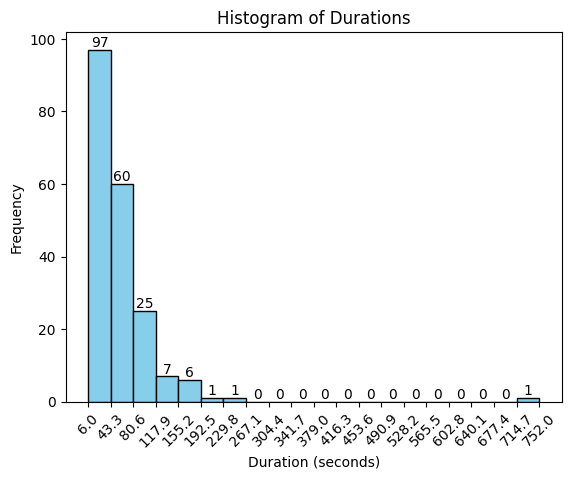

In [ ]:
import matplotlib.pyplot as plt

durations = []

# Loop through the dictionary to process only non-empty lists
for key, value in dict_episodios.items():
    if value:  # Check if the list is not empty
        for time_data in value:
            duration = time_data['end'] - time_data['start']
            durations.append(duration)

# Plotting the histogram
n, bins, patches = plt.hist(durations, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

# Set the x-ticks based on the bin edges
plt.xticks(bins, rotation=45)

# Add values on top of the bars
for i in range(len(patches)):
    height = patches[i].get_height()
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, height, str(int(height)),
             ha='center', va='bottom', fontsize=10)

plt.show()


# Verificar el total de archivos

In [ ]:
import glob
import re

def extraer_file_names_desde_txt(ruta_archivo):
    """
    Lee un archivo de texto que contiene bloques con líneas tipo:
      File Name: chb01_01.edf
    y devuelve una lista de file names encontrados en ese archivo.
    """
    file_names = set()
    with open(ruta_archivo, "r") as f:
        lineas = f.readlines()
        for linea in lineas:
            if "File Name:" in linea:
                match = re.search(r"File Name:\s*(\S+)", linea)
                if match:
                    file_names.add(match.group(1))
    return list(file_names)

def extraer_file_names_varios_txt(patron_archivos):
    """
    Recorre todos los archivos .txt que cumplan con el patrón y
    devuelve un conjunto de file names únicos encontrados.
    """
    file_names = set()
    lista_txt = glob.glob(patron_archivos)
    for ruta_txt in lista_txt:
        names = extraer_file_names_desde_txt(ruta_txt)
        file_names.update(names)
    return file_names

if __name__ == "__main__":
    patron = "/mnt/DGX0Raid/databases/CHB_data/txt_Files/*.txt"
    file_names = extraer_file_names_varios_txt(patron)
    total_file_names = len(file_names)
    print("Total de file names encontrados:", total_file_names)


Total de file names encontrados: 676


# Creación de listas normal y epiléptica con los nombres de los archivos

In [ ]:
import glob
import re

def clasificar_archivos_desde_txt(ruta_archivo):
    """
    Lee un archivo de texto que contiene información en líneas como:
      File Name: chb01_01.edf
      Number of Seizures in File: 0
    y clasifica el archivo como normal o con epilepsia según el número de seizures.

    Retorna dos listas:
      - normal_files (contiene los nombres de archivo EDF con 0 seizures)
      - epileptic_files (contiene los nombres de archivo EDF con >=1 seizures)
    """
    normal_files = []
    epileptic_files = []

    current_file_name = None

    with open(ruta_archivo, "r") as f:
        lineas = f.readlines()

        for linea in lineas:
            # Detectar el nombre del archivo EDF
            if "File Name:" in linea:
                match_file = re.search(r"File Name:\s*(\S+)", linea)
                if match_file:
                    current_file_name = match_file.group(1)

            # Detectar el número de seizures en el archivo
            if "Number of Seizures in File:" in linea:
                match_seizures = re.search(r"Number of Seizures in File:\s*(\d+)", linea)
                if match_seizures and current_file_name:
                    num_seizures = int(match_seizures.group(1))

                    if num_seizures == 0:
                        normal_files.append(current_file_name)
                    else:
                        epileptic_files.append(current_file_name)

                    # Reseteamos el current_file_name para el siguiente bloque
                    current_file_name = None

    return normal_files, epileptic_files

def clasificar_archivos_varios_txt(patron_archivos):
    """
    Recorre todos los archivos .txt que cumplan con el patrón y
    genera dos listas globales:
      - normal_files (archivos EDF con 0 seizures)
      - epileptic_files (archivos EDF con >=1 seizures)
    """
    normal_files = set()
    epileptic_files = set()

    lista_txt = glob.glob(patron_archivos)
    for ruta_txt in lista_txt:
        nf, ef = clasificar_archivos_desde_txt(ruta_txt)
        normal_files.update(nf)
        epileptic_files.update(ef)

    return list(normal_files), list(epileptic_files)

def ordenar_por_numero_chb(lista_archivos):
    """
    Ordena una lista de nombres de archivos según el número que aparece
    justo después de "chb". Por ejemplo, 'chb01_01.edf' se ordenará antes de 'chb10_03.edf'.
    """
    # Usamos re.IGNORECASE por si acaso el prefijo está en mayúsculas o minúsculas.
    return sorted(lista_archivos, key=lambda x: int(re.search(r'chb(\d+)', x, re.IGNORECASE).group(1)))

if __name__ == "__main__":
    patron = "/mnt/DGX0Raid/databases/CHB_data/txt_Files/*.txt"
    normal_list, epileptic_list = clasificar_archivos_varios_txt(patron)

    # Ordenar las listas según el número que sigue a "chb"
    normal_list_ordenada = ordenar_por_numero_chb(normal_list)
    epileptic_list_ordenada = ordenar_por_numero_chb(epileptic_list)

    print("Archivos normales (0 seizures) ordenados:")
    for f in normal_list_ordenada:
        print("  ", f)

    print("\nArchivos con epilepsia (>=1 seizures) ordenados:")
    for f in epileptic_list_ordenada:
        print("  ", f)

    # Si necesitas conocer el total de file names (únicos) en cada categoría:
    print("\nTotal de archivos normales:", len(normal_list_ordenada))
    print("Total de archivos con epilepsia:", len(epileptic_list_ordenada))


Archivos normales (0 seizures) ordenados:
   chb01_32.edf
   chb01_40.edf
   chb01_39.edf
   chb01_34.edf
   chb01_01.edf
   chb01_31.edf
   chb01_22.edf
   chb01_42.edf
   chb01_09.edf
   chb01_11.edf
   chb01_13.edf
   chb01_24.edf
   chb01_02.edf
   chb01_43.edf
   chb01_33.edf
   chb01_29.edf
   chb01_25.edf
   chb01_05.edf
   chb01_07.edf
   chb01_38.edf
   chb01_46.edf
   chb01_06.edf
   chb01_41.edf
   chb01_10.edf
   chb01_12.edf
   chb01_17.edf
   chb01_23.edf
   chb01_37.edf
   chb01_20.edf
   chb01_36.edf
   chb01_27.edf
   chb01_08.edf
   chb01_14.edf
   chb01_19.edf
   chb01_30.edf
   chb02_10.edf
   chb02_07.edf
   chb02_06.edf
   chb02_12.edf
   chb02_31.edf
   chb02_11.edf
   chb02_28.edf
   chb02_27.edf
   chb02_17.edf
   chb02_26.edf
   chb02_04.edf
   chb02_18.edf
   chb02_32.edf
   chb02_21.edf
   chb02_01.edf
   chb02_20.edf
   chb02_05.edf
   chb02_14.edf
   chb02_33.edf
   chb02_25.edf
   chb02_35.edf
   chb02_29.edf
   chb02_15.edf
   chb02_03.edf
   chb02_23.ed

# Muestreo de archivos edf normales y balanceo de clases

In [ ]:
import random

# Ejemplo: Supongamos que estos son tus datos.
# La lista 'epileptic_records' contiene 198 episodios epilepticos.
# La lista 'normal_records' contiene más de 400 registros normales.
# (En este ejemplo, usaremos números para ilustrar. En tu caso, serán tus objetos o registros.)

# Realizamos un muestreo aleatorio sin reemplazo para seleccionar 198 registros normales.çr
random.seed(42)  # Para reproducibilidad
balanced_normal_records = random.sample(normal_list_ordenada, 198)

# Ahora tenemos 198 registros epilepticos y 198 registros normales.
print("Número de registros epilepticos:", len(epileptic_list_ordenada))
print("Número de registros normales muestreados:", len(balanced_normal_records))

# Opcional: combinar ambas clases en un solo conjunto balanceado
balanced_dataset = {
    "epileptic": epileptic_list_ordenada,
    "normal": balanced_normal_records
}

# Imprimir para verificar
print("\nDatos balanceados:")
print("Episodios epilepticos:", balanced_dataset["epileptic"])
print("Registros normales muestreados:", balanced_dataset["normal"])


Número de registros epilepticos: 141
Número de registros normales muestreados: 198

Datos balanceados:
Episodios epilepticos: ['chb01_03.edf', 'chb01_04.edf', 'chb01_18.edf', 'chb01_16.edf', 'chb01_15.edf', 'chb01_21.edf', 'chb01_26.edf', 'chb02_19.edf', 'chb02_16+.edf', 'chb02_16.edf', 'chb03_34.edf', 'chb03_03.edf', 'chb03_35.edf', 'chb03_02.edf', 'chb03_36.edf', 'chb03_04.edf', 'chb03_01.edf', 'chb04_05.edf', 'chb04_08.edf', 'chb04_28.edf', 'chb05_13.edf', 'chb05_22.edf', 'chb05_06.edf', 'chb05_17.edf', 'chb05_16.edf', 'chb06_10.edf', 'chb06_09.edf', 'chb06_24.edf', 'chb06_04.edf', 'chb06_13.edf', 'chb06_01.edf', 'chb06_18.edf', 'chb07_19.edf', 'chb07_13.edf', 'chb07_12.edf', 'chb08_02.edf', 'chb08_05.edf', 'chb08_13.edf', 'chb08_21.edf', 'chb08_11.edf', 'chb09_06.edf', 'chb09_19.edf', 'chb09_08.edf', 'chb10_20.edf', 'chb10_27.edf', 'chb10_38.edf', 'chb10_89.edf', 'chb10_30.edf', 'chb10_31.edf', 'chb10_12.edf', 'chb11_92.edf', 'chb11_99.edf', 'chb11_82.edf', 'chb12_08.edf', 'chb12_0

In [ ]:
balanced_normal_records

['chb04_18.edf',
 'chb01_14.edf',
 'chb12_37.edf',
 'chb11_17.edf',
 'chb09_11.edf',
 'chb05_34.edf',
 'chb04_31.edf',
 'chb03_26.edf',
 'chb19_23.edf',
 'chb01_10.edf',
 'chb01_27.edf',
 'chb03_05.edf',
 'chb09_03.edf',
 'chb10_01.edf',
 'chb22_09.edf',
 'chb01_09.edf',
 'chb08_04.edf',
 'chb19_09.edf',
 'chb09_12.edf',
 'chb20_07.edf',
 'chb12_39.edf',
 'chb01_40.edf',
 'chb05_04.edf',
 'chb22_01.edf',
 'chb06_03.edf',
 'chb23_19.edf',
 'chb03_20.edf',
 'chb04_42.edf',
 'chb21_07.edf',
 'chb17b_57.edf',
 'chb06_15.edf',
 'chb02_25.edf',
 'chb02_30.edf',
 'chb07_16.edf',
 'chb02_21.edf',
 'chb07_08.edf',
 'chb19_14.edf',
 'chb06_05.edf',
 'chb13_36.edf',
 'chb04_12.edf',
 'chb18_07.edf',
 'chb01_25.edf',
 'chb16_19.edf',
 'chb10_15.edf',
 'chb11_61.edf',
 'chb02_12.edf',
 'chb21_04.edf',
 'chb07_17.edf',
 'chb02_03.edf',
 'chb12_20.edf',
 'chb05_31.edf',
 'chb19_18.edf',
 'chb14_01.edf',
 'chb14_14.edf',
 'chb20_28.edf',
 'chb19_21.edf',
 'chb07_09.edf',
 'chb13_24.edf',
 'chb03_10.ed

In [ ]:
# Combina las listas de archivos normales y epilepticos
archivos_validos = set(balanced_normal_records + epileptic_list_ordenada)

# Crear nuevo diccionario filtrado
dict_filtrado = {k: v for k, v in dict_episodios.items() if k in archivos_validos}

# Verificación opcional
print(f"\nNúmero de archivos en el diccionario original: {len(dict_episodios)}")
print(f"Número de archivos en el nuevo diccionario filtrado: {len(dict_filtrado)}")

# Imprimir algunos resultados
for edf_name, episodios in list(dict_filtrado.items())[:5]:  # Solo muestra los primeros 5
    print(f"\nArchivo: {edf_name}")
    for i, epi in enumerate(episodios, 1):
        print(f"  Episodio {i}: Start = {epi['start']}, End = {epi['end']}")



Número de archivos en el diccionario original: 676
Número de archivos en el nuevo diccionario filtrado: 339

Archivo: chb14_02.edf

Archivo: chb14_03.edf
  Episodio 1: Start = 1986, End = 2000

Archivo: chb14_04.edf
  Episodio 1: Start = 1372, End = 1392
  Episodio 2: Start = 2817, End = 2839

Archivo: chb14_06.edf
  Episodio 1: Start = 1911, End = 1925

Archivo: chb14_07.edf


In [ ]:
dict_filtrado

{'chb14_01.edf': [],
 'chb14_03.edf': [{'start': 1986, 'end': 2000}],
 'chb14_04.edf': [{'start': 1372, 'end': 1392}, {'start': 2817, 'end': 2839}],
 'chb14_06.edf': [{'start': 1911, 'end': 1925}],
 'chb14_07.edf': [],
 'chb14_11.edf': [{'start': 1838, 'end': 1879}],
 'chb14_12.edf': [],
 'chb14_16.edf': [],
 'chb14_17.edf': [{'start': 3239, 'end': 3259}],
 'chb14_18.edf': [{'start': 1039, 'end': 1061}],
 'chb14_25.edf': [],
 'chb14_27.edf': [{'start': 2833, 'end': 2849}],
 'chb14_29.edf': [],
 'chb14_37.edf': [],
 'chb14_39.edf': [],
 'chb09_01.edf': [],
 'chb09_02.edf': [],
 'chb09_03.edf': [],
 'chb09_06.edf': [{'start': 12231, 'end': 12295}],
 'chb09_08.edf': [{'start': 2951, 'end': 3030}, {'start': 9196, 'end': 9267}],
 'chb09_12.edf': [],
 'chb09_14.edf': [],
 'chb09_17.edf': [],
 'chb09_19.edf': [{'start': 5299, 'end': 5361}],
 'chb11_02.edf': [],
 'chb11_04.edf': [],
 'chb11_05.edf': [],
 'chb11_12.edf': [],
 'chb11_15.edf': [],
 'chb11_19.edf': [],
 'chb11_25.edf': [],
 'chb11

# Uso de GPU

In [ ]:
import torch

# Seleccionar el dispositivo: 'cuda' si hay GPU, de lo contrario 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

if device.type == 'cuda':
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))

Usando dispositivo: cuda
Nombre de la GPU: Tesla V100-DGXS-32GB


# Extracción de ventanas de 21 segundos en señales epilépticas y normales

In [ ]:
import mne
import numpy as np
import os

def resolve_duplicate_channels(raw):
    """
    Resolves duplicate channel names by renaming them with a suffix.
    Uses MNE's rename_channels method to ensure the correct approach.
    """
    ch_names = raw.info['ch_names']

    # Create a dictionary to count duplicates
    unique_ch_names = {}
    new_ch_names = {}

    # Detect and rename duplicates
    for ch in ch_names:
        if ch not in unique_ch_names:
            unique_ch_names[ch] = 1
            new_ch_names[ch] = ch
        else:
            unique_ch_names[ch] += 1
            new_ch_names[ch] = f"{ch}.{unique_ch_names[ch]}"

    # Apply the new names using MNE's rename_channels method
    raw.rename_channels(new_ch_names)

    return raw

def load_edf_lazy(edf_path):
    """
    Lazily loads the EDF file when needed.
    """
    # This function will return the raw MNE object for lazy loading
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    return raw

def get_segment(raw, start_sec, end_sec, window_samples, sfreq, n_channels):
    """
    Helper function to load a specific segment of the data lazily.
    """
    start_idx = int(start_sec * sfreq)
    end_idx = int(end_sec * sfreq)

    # Aseguramos que el segmento sea de 21 segundos
    segment_start = max(0, start_idx)
    segment_end = min(raw.n_times, segment_start + window_samples)

    # Extraer los datos del segmento correspondiente
    segment = raw.get_data(start=segment_start, stop=segment_end)  # (n_canales, num_muestras_segmento)

    # Si el segmento no es de 21 segundos, rellenamos con ceros
    if segment.shape[1] < window_samples:
        padded = np.zeros((n_channels, window_samples))
        padded[:, :segment.shape[1]] = segment
        segment = padded

    return segment

def process_edf_dictionary(dict_episodios, edf_folder):
    """
    A partir de un diccionario donde:
        dict_episodios[file_name] = [{'start': X, 'end': Y}, ...]  (o lista vacía si no hay episodios)
    Carga cada archivo EDF de manera lazy y:
      - Para cada episodio en la lista, almacena el segmento completo de 21 segundos.
      - Si la lista de episodios está vacía, extrae los primeros 21 segundos desde el inicio.

    Se retornan los segmentos completos de cada canal junto con la etiqueta correspondiente (0 para normal, 1 para epiléptico).
    """
    results = {}

    for file_name, episodes in dict_episodios.items():
        edf_path = os.path.join(edf_folder, file_name)

        # Carga la señal de manera lazy
        raw = load_edf_lazy(edf_path)

        # Resolviendo nombres duplicados de canales
        raw = resolve_duplicate_channels(raw)

        # Información sobre el archivo
        eeg_data = raw.get_data()  # (n_canales, n_muestras)
        sfreq = raw.info['sfreq']
        n_channels = eeg_data.shape[0]
        window_samples = int(21 * sfreq)  # Tomamos siempre 21 segundos

        # Inicializamos un diccionario para almacenar los segmentos por canal
        channel_segments = {f"channel_{i+1}": [] for i in range(n_channels)}

        if len(episodes) == 0:
            # Archivo sin episodios epilépticos -> extraemos solo los primeros 21 segundos desde el inicio
            segment_full = get_segment(raw, 0, 21, window_samples, sfreq, n_channels)

            # Separamos el segmento por canales (cada canal es una señal 1D)
            for ch in range(n_channels):
                channel_segments[f"channel_{ch+1}"].append((segment_full[ch, :], 0))  # Etiqueta 0 (normal)
        else:
            # Archivo con 1 o más episodios
            for epi in episodes:
                start_sec = epi['start']
                end_sec = epi['end']

                segment = get_segment(raw, start_sec, end_sec, window_samples, sfreq, n_channels)

                # Separamos el segmento completo por canales
                for ch in range(n_channels):
                    # Etiqueta 1 para evento epiléptico, 0 para normal
                    label = 1 if epi else 0
                    channel_segments[f"channel_{ch+1}"].append((segment[ch, :], label))

        results[file_name] = channel_segments

    return results

if __name__ == "__main__":
    # Carpeta donde se ubican los archivos EDF
    edf_folder = "/mnt/DGX0Raid/databases/CHB_data/CHB"

    # Procesar el diccionario para separar los segmentos por canales y agregar etiquetas
    dict_ventanas = process_edf_dictionary(dict_filtrado, edf_folder)

    # Ejemplo de impresión de resultados
    for file_name, channel_dict in dict_ventanas.items():
        print(f"\nArchivo: {file_name}")
        for channel, segments in channel_dict.items():
            print(f"  {channel}: {len(segments)} segmentos")
            # Imprimir la forma del primer segmento de este canal (si existe)
            if segments:
                print(f"    Ejemplo segmento: forma {segments[0][0].shape} (muestras,)")


<ipython-input-9-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-9-f18ec28d622b>:35: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-9-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-9-f18ec28d622b>:35: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-9-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for dupl

KeyboardInterrupt: 

In [ ]:
dict_ventanas

{'chb14_01.edf': {'channel_1': [(array([-3.37973138e-05,  1.95360195e-07,  1.95360195e-07, ...,
           -8.22466422e-05, -8.38095238e-05, -7.67765568e-05]),
    0)],
  'channel_2': [(array([-4.31746032e-05,  1.95360195e-07,  1.95360195e-07, ...,
            4.90354090e-05,  4.20024420e-05,  4.63003663e-05]),
    0)],
  'channel_3': [(array([ 8.73260073e-05,  1.95360195e-07,  1.95360195e-07, ...,
           -1.93406593e-05, -2.16849817e-05, -1.89499389e-05]),
    0)],
  'channel_4': [(array([ 7.28693529e-05,  1.95360195e-07,  1.95360195e-07, ...,
           -5.88034188e-05, -5.84126984e-05, -6.11477411e-05]),
    0)],
  'channel_5': [(array([-1.e-06, -1.e-06, -1.e-06, ..., -1.e-06, -1.e-06, -1.e-06]),
    0)],
  'channel_6': [(array([-8.84981685e-05,  1.95360195e-07,  1.95360195e-07, ...,
           -9.51404151e-05, -1.02564103e-04, -1.03736264e-04]),
    0)],
  'channel_7': [(array([ 7.59951160e-05,  1.95360195e-07,  1.95360195e-07, ...,
           -5.86080586e-07, -5.66544567e-06, 

# Kshape con generadores

In [ ]:
import numpy as np
import cupy as cp  # For GPU operations
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split, cross_val_score
from tslearn.clustering import KShape

# Función para preparar los datos de KShape
def prepare_kshape_data(dict_ventanas, target_length=5376):
    """
    Convierte los segmentos de EEG en un dataset adecuado para KShape de manera perezosa (lazy).
    Los segmentos se rellenan o recortan a una longitud fija.
    """
    print("Preparing KShape data...")

    # Generador para procesar los segmentos
    for file_name, channel_dict in dict_ventanas.items():
        for channel, segments in channel_dict.items():
            for segment, label in segments:
                # Rellenar o recortar el segmento a la longitud fija
                if len(segment) < target_length:
                    # Zero-padding si el segmento es más corto que la longitud objetivo
                    padded_segment = np.pad(segment, (0, target_length - len(segment)), 'constant')
                else:
                    # Recortar si el segmento es más largo que la longitud objetivo
                    padded_segment = segment[:target_length]

                # Convertir el segmento de NumPy a CuPy para procesamiento en GPU
                padded_segment_gpu = cp.array(padded_segment)

                # Devolver el segmento procesado y su etiqueta
                yield padded_segment_gpu, label

    print("KShape data prepared.")

# Función para cargar y procesar los datos (usando el diccionario dict_ventanas generado desde los datos EEG)
def process_kshape_data(dict_ventanas):
    print("Processing KShape data...")

    # Inicializamos las listas para almacenar los segmentos y las etiquetas
    all_segments = []
    all_labels = []

    # Usar el generador para obtener los segmentos
    for segment, label in prepare_kshape_data(dict_ventanas):
        all_segments.append(segment)
        all_labels.append(label)

    # Convertir las listas de segmentos y etiquetas en arrays
    # Usamos .get() para convertir explícitamente de CuPy a NumPy
    # Convertir las listas de segmentos y etiquetas en arrays
    all_segments = np.array([seg.get() for seg in all_segments])  # Convertir de CuPy a NumPy
    all_labels = np.array(all_labels)

    # Verificar la forma del array de segmentos para asegurarse de que es homogéneo
    if all_segments.ndim != 2:
        raise ValueError(f"Los segmentos no tienen una forma homogénea. Forma detectada: {all_segments.shape}")

    # Escalar los datos usando TimeSeriesScalerMeanVariance
    scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
    all_segments_scaled = scaler.fit_transform(all_segments)

    # Dividir los datos para entrenamiento y prueba (80-20)
    X_train, X_test, y_train, y_test = train_test_split(all_segments_scaled, all_labels, test_size=0.2, random_state=42)

    print(f"Data split into training and testing sets. Training size: {len(X_train)}, Testing size: {len(X_test)}")
    print("Data scaled.")

    return X_train, X_test, y_train, y_test

# Ejemplo de cómo usar la función
dict_ventanas = process_edf_dictionary(dict_filtrado, edf_folder)
X_train_scaled, X_test_scaled, y_train, y_test = process_kshape_data(dict_ventanas)

# Experiment with different values for tol and n_init
tol_values = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
n_init_values = [1, 3, 5, 7, 10]

# Initialize the best performance tracking variables
best_f1_score = -1
best_tol = None
best_n_init = None

# Perform cross-validation with 10 folds
for tol in tol_values:
    for n_init in n_init_values:
        model = KShape(n_clusters=2, n_init=n_init, tol=tol, random_state=0)

        # Perform cross-validation with 10 folds
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy')
        mean_cv_score = np.mean(cv_scores)

        print(f"tolerance: {tol} | n_init: {n_init} | Mean CV Accuracy: {mean_cv_score:.4f}")

        if mean_cv_score > best_f1_score:
            best_f1_score = mean_cv_score
            best_tol = tol
            best_n_init = n_init

# Train the model with the best parameters
print(f"\nBest parameters found - tol: {best_tol}, n_init: {best_n_init}")
model = KShape(n_clusters=2, n_init=best_n_init, tol=best_tol, random_state=0)
model.fit(X_train_scaled)

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall = recall_score(y_train, y_pred_train, average='weighted')
f1 = f1_score(y_train, y_pred_train, average='weighted')

print(f"\nAccuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_train, y_pred_train)
print("\nConfusion Matrix Train:")
print(conf_matrix)
print("\nClassification Report Train:")
print(classification_report(y_train, y_pred_train))

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix Test:")
print(conf_matrix)
print("\nClassification Report Test:")
print(classification_report(y_test, y_pred_test))

# Visualization of signals by cluster with centroids in red
centroids = model.cluster_centers_

plt.figure(figsize=(15, 6))
for cluster_idx in range(2):  # Only 2 clusters
    plt.subplot(1, 2, cluster_idx + 1)
    cluster_signals = X_test_scaled[y_pred_test == cluster_idx]

    for ts in cluster_signals:
        plt.plot(ts.ravel(), color='gray', alpha=0.4)

    plt.plot(centroids[cluster_idx].ravel(), color='red', linewidth=2, label='Centroid')
    plt.title(f'Cluster {cluster_idx}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.suptitle("Signals by Cluster with Centroids in Red", y=1.02, fontsize=16)
plt.show()

<ipython-input-8-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-8-f18ec28d622b>:35: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-8-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-8-f18ec28d622b>:35: RuntimeWarning: Scaling factor is not defined in following channels:
--0, --1, --2, --3, --4
  raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
<ipython-input-8-f18ec28d622b>:35: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8', '-'}. Applying running numbers for dupl

Processing KShape data...
Preparing KShape data...
KShape data prepared.
Data split into training and testing sets. Training size: 8391, Testing size: 2098
Data scaled.


/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


KeyboardInterrupt: 

# Time Series K-means

In [ ]:
import numpy as np
import cupy as cp  # For GPU operations
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Function to prepare Time Series KMeans data from the EEG windows using CuPy for GPU support
def prepare_kmeans_data(dict_ventanas):
    """
    Converts the windows from each channel into a time-series dataset suitable for KMeans clustering.
    """
    all_windows = []
    all_labels = []

    # Flatten all windows into one list, where each window is a time series
    for file_name, channel_dict in dict_ventanas.items():
        for channel, windows in channel_dict.items():
            for window, label in windows:
                all_windows.append(window)
                all_labels.append(label)

    # Convert the windows into a time-series dataset (tslearn compatible)
    all_windows = np.array(all_windows)

    # Convert numpy arrays to CuPy arrays for GPU processing
    all_windows_gpu = cp.array(all_windows)

    # Explicitly convert the CuPy array to NumPy before passing it to tslearn
    return all_windows_gpu.get(), np.array(all_labels)  # Return the windows and labels separately


# Function to load and process the data (using the dict_ventanas generated from EEG data)
def process_kmeans_data(dict_ventanas):
    # Prepare the Time Series KMeans data from the EEG windows and extract labels
    X, labels = prepare_kmeans_data(dict_ventanas)

    # Split the data for training and testing (using a 80-20 split)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test


# Prepare the Time Series KMeans data
X_train, X_test, y_train, y_test = process_kmeans_data(dict_ventanas)

# Initialize the TimeSeriesKMeans model
model = TimeSeriesKMeans(n_clusters=2, metric="euclidean", verbose=True)

# Fit the model on the training data
y_pred_train = model.fit_predict(X_train)

# Predictions on the test data
y_pred_test = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nAccuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Visualization of signals by cluster with centroids in red
centroids = model.cluster_centers_

plt.figure(figsize=(15, 6))
for cluster_idx in range(2):  # Only 2 clusters
    plt.subplot(1, 2, cluster_idx + 1)
    cluster_signals = X_test[y_pred_test == cluster_idx]

    for ts in cluster_signals:
        plt.plot(ts.ravel(), color='gray', alpha=0.4)

    plt.plot(centroids[cluster_idx].ravel(), color='red', linewidth=2, label='Centroid')
    plt.title(f'Cluster {cluster_idx}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

plt.tight_layout()
plt.suptitle("Signals by Cluster with Centroids in Red", y=1.02, fontsize=16)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Function to prepare Time Series KMeans data from the EEG windows using CuPy for GPU support
def prepare_kmeans_data(dict_ventanas):
    """
    Converts the windows from each channel into a time-series dataset suitable for KMeans clustering.
    """
    all_windows = []
    all_labels = []

    # Flatten all windows into one list, where each window is a time series
    for file_name, channel_dict in dict_ventanas.items():
        for channel, windows in channel_dict.items():
            for window, label in windows:
                all_windows.append(window)
                all_labels.append(label)

    # Convert the windows into a time-series dataset (tslearn compatible)
    all_windows = np.array(all_windows)

    # Convert numpy arrays to CuPy arrays for GPU processing
    all_windows_gpu = cp.array(all_windows)

    # Explicitly convert the CuPy array to NumPy before passing it to tslearn
    return all_windows_gpu.get(), np.array(all_labels)  # Return the windows and labels separately

# 1) Carga y prepara todo el dataset
X, labels = prepare_kmeans_data(dict_ventanas)

# 2) Divide en entrenamiento+validación vs. prueba (80/20), estratificando por etiqueta
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, labels, test_size=0.2, random_state=42, stratify=labels
)

# 3) Define la malla de hiperparámetros
param_grid = {
    "n_clusters": [2],
    "metric": ["euclidean", "dtw"],
    "n_init": [1, 3, 5, 7, 10],
    "tol": [1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
    "random_state": [42]
}

# 4) Prepara el CV estratificado de 10 folds sobre el set de train+val
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_score = -np.inf
best_params = None

# 5) Bucle de GridSearch manual
for params in ParameterGrid(param_grid):
    fold_scores = []
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        X_tr, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_tr, y_val = y_trainval[train_idx], y_trainval[val_idx]

        km = TimeSeriesKMeans(**params, verbose=False, random_state=42)
        km.fit(X_tr)
        y_pred = km.predict(X_val)
        fold_scores.append(f1_score(y_val, y_pred, average="weighted"))

    mean_score = np.mean(fold_scores)
    print(f"Params: {params} → Mean CV F1: {mean_score:.4f}")
    if mean_score > best_score:
        best_score, best_params = mean_score, params

print(f"\nBest CV params: {best_params}  (F1={best_score:.4f})\n")

# 6) Reentrena el mejor modelo con todo el train+val
best_km = TimeSeriesKMeans(**best_params, verbose=True, random_state=42)
best_km.fit(X_trainval)

# 7) Evalúa en el set de prueba independiente
y_pred_test = best_km.predict(X_test)
print("=== Test set evaluation ===")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))
